# **CS412 - HW2**

In this assignment, we will evaluate your knowledge on Neural Networks, Dimensionality Reduction and Clustering concepts. We are providing you a face classification dataset, and you will use a pretrained model to obtain the embeddings of each face image on this dataset.

With these embeddings, you will apply PCA algorithm for dimensionality reduction and use nearest neighbor search to identify images that are closest to your own picture.

### **Submission**: You will lose points if you don't follow instructions here
Name this notebook as: **YourName_Surname_hw2.ipynb** from the top left corner (e.g. for Veysel Kaya -> Veysel_Kaya_hw2.ipynb)
Next, download this notebook as a *.ipynb document and upload* it on SuCourse.

Please pay attention to the formatting! You will lose __5 points__ if the outputs are not visible meaning that you haven't executed the cells. Also another __5 points__ if your notebook doesn't follow the naming conversion specified above.


## The dataset
The dataset we are going to work with in this assignment is LFW Face. It is a public benchmark dataset for face verification. More information can be found on here http://vis-www.cs.umass.edu/lfw/index.html


We'll download the tgz file and unpack it. A [TGZ](https://en.wikipedia.org/wiki/Gzip) file is a Unix .TAR archive compressed with Gnu Zip (.GZIP) compression to reduce the file size.
After unpacking, you'll see a *lfw* folder with multiple directories underneath, where each folder is named after a person, and contains the associated face images.

In [ ]:
! wget http://vis-www.cs.umass.edu/lfw/lfw.tgz # download the file
! tar zxf lfw.tgz # unpack the content

--2023-01-15 15:36:26--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  73.4MB/s    in 2.3s    

2023-01-15 15:36:28 (73.4 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



With [glob](https://docs.python.org/3/library/glob.html) module, we'll find all the pathnames under the *lfw* folder, matching a recursive pattern where we visit all the images, and collect the paths in *list_imgs*.

In [ ]:
import glob
data_dir = 'lfw'
list_imgs = glob.glob(data_dir + "/**/*.jpg")
print(f"Number of .jpg files in '{data_dir}' folder are {len(list_imgs)}.")

Number of .jpg files in 'lfw' folder are 13238.


# The dataloader

In order to feed the data to our model, we need to create a dataloader. [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) wraps an iterable around the Dataset to enable easy access to the samples. However, we can not directly feed .jpg files as samples to the model. First, they need to be transformed into [tensors](https://pytorch.org/docs/stable/tensors.html;). To make this happen, we'll benefit from [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html). With *transforms*, we can, not only obtain tensors, but also apply different types of transformations and image augmentations, where PyTorch provides many methods.

**Important:** Create a new folder under lfw folder and copy your own **face pictures** into your new folder to compare to the rest of the images within this dataset. So that, you can get the embedding of your own face picture too.

Note: If you have any memory allocations problem, specifically if you use cuda GPUs, try to reduce batch size so that each data batch can fit into memory of your device besides the model itself.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# create a simple transform pipeline where we only resize the image and convert it to tensor.
myTransform = transforms.Compose([
        transforms.Resize((160, 160)), # the model we will be using was trained on 160x160 pixel images.
        transforms.ToTensor(),
    ])

image_datasets = datasets.ImageFolder(data_dir, transform=myTransform) # ImageFolder method will recursively collect the image paths under your specified directory, and apply your transform
# image_datasets object has a list attribute called .imgs, where you ll notice each tuple contains the path of the image, and its associated label
# ImageFolder method will label the images as integers, depending on the folder of the person. There can be duplicated labels if a person has multiple images.

batchSize = 64
myDataloader = DataLoader(image_datasets, batch_size=batchSize, shuffle=False) # We will feed the data into our model as batches.
# I.e. if the batch size is 64, at each iteration, the dataloader will load a tensor containing 64 images from the dataset.
# The dataset has 13233 images without our own pictures, if we set batch size to 64, there will be 13233//64 iterations for the dataloader.
# We exclusively set shuffle to False, because the order will be important for later on.


In [ ]:
# Let's look at image_datasets.imgs
print(image_datasets.imgs[:10])

# Tip: You can use image_datasets.imgs list to obtain image paths at the PCA and NearestNeigbor part, later on this assignment.

[('lfw/AJ_Cook/AJ_Cook_0001.jpg', 0), ('lfw/AJ_Lamas/AJ_Lamas_0001.jpg', 1), ('lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg', 2), ('lfw/Aaron_Guiel/Aaron_Guiel_0001.jpg', 3), ('lfw/Aaron_Patterson/Aaron_Patterson_0001.jpg', 4), ('lfw/Aaron_Peirsol/Aaron_Peirsol_0001.jpg', 5), ('lfw/Aaron_Peirsol/Aaron_Peirsol_0002.jpg', 5), ('lfw/Aaron_Peirsol/Aaron_Peirsol_0003.jpg', 5), ('lfw/Aaron_Peirsol/Aaron_Peirsol_0004.jpg', 5), ('lfw/Aaron_Pena/Aaron_Pena_0001.jpg', 6)]


torch.Size([64, 3, 160, 160])
torch.Size([3, 160, 160])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.7843, 0.7843, 0.7804],
         [0.0039, 0.0039, 0.0039,  ..., 0.7843, 0.7843, 0.7804],
         [0.0078, 0.0039, 0.0039,  ..., 0.7882, 0.7922, 0.7882]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.6588, 0.6588, 0.6549],
         [0.0039, 0.0039, 0.0039,  ..., 0.6588, 0.6588, 0.6549],
         [0.0078, 0.0039, 0.0039,  ..., 0.6627, 0.6667, 0.6627]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
  

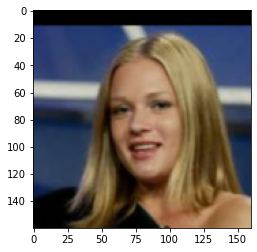

tensor(0)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Let's iterate with our data loader, and investigate the first batch

for currentBatchImgs, currentBatchLabels in myDataloader:
    # Lets look at the shape of the batch tensor
    print(currentBatchImgs.shape)

    # Lets look at the shape of the first image contained in this tensor and check out what it actually is
    print(currentBatchImgs[0].shape)
    print(currentBatchImgs[0])

    # Lets show the actual first image itself after converting back from tensor to array
    plt.imshow((currentBatchImgs[0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
    plt.grid(False)
    plt.show()

    # Lets print the label of the first image
    print(currentBatchLabels[0])
    break

# As you can see from the first output, the dataloader will load a tensor of our batch which has a shape in the form of [BatchSize, RGB Channels, Width pixels, Height pixels]

# The model

To obtain the model of our choice, we will use [*facenet_pytorch*](https://github.com/timesler/facenet-pytorch) module which can be installed through [*pip*](https://pypi.org/).

The model of our choice is [InceptionResNetV1](https://iq.opengenus.org/inception-resnet-v1/) trained on [VGGFace2](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8373813) dataset.

In [ ]:
! pip install facenet_pytorch # We use pip to install our module containing the architecture of our model
from facenet_pytorch import InceptionResnetV1 # Lets import the method that will build the model

# Below function will build the model, download the weights and load to the model
# We also put the model into eval state; https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
model = InceptionResnetV1(pretrained='vggface2').eval()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
# Just for the folks having cuda GPUs (nvidia):
#   However, you need to connect through your local runtime.
#   If you dont move the model and have a cuda GPU, PyTorch defaults to the CPU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.6 MB/s eta 0:00:00


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
# Let's take a look at our model to understand its architecture.
print(model)

# You can see the layer names from the output, such as: conv2d_1a, maxpool_3a, repeat_1, avgpool_1a, last_linear, last_bn etc ...
# You can see more on how the model is constructed via https://github.com/timesler/facenet-pytorch/blob/555aa4bec20ca3e7c2ead14e7e39d5bbce203e4b/models/inception_resnet_v1.py

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In order to get the embedding for each image, we will register a forward hook to a layer in the model architecture. The hook will be called every time after forward() has computed an output. It should have the following signature:

```
hook(module, input, output) -> None or modified output
```
Below, you will see the `get_embeddings(module, input, output)` function in such format. We will use this function to get an output from a particular layer in the model at each forward pass.

However, you need to decide on the layer which you think we should get the embeddings from.

# Question 1 (15 Points)

You need to decide which embedding layer you would like to work with. Identify the layer name using the cell above and assing name of the layer to the variable below (5 points). Make sure to justify your decision (10 points).

[link text](https://)### Explain here =>
I tried 3-4 layers and last_linear gave best results to me. Algorithm can learn linear relationships in data, in PAC algorithm linear layer works more efficiently and can find similarities or differences.

In [ ]:
LAYER_NAME = "last_linear"

In [ ]:
layer = model._modules.get(LAYER_NAME)

def get_embeddings(module, input, output):
    output = output.detach().cpu().numpy().tolist() # You dont need to change this line
    outputs.append(output) #populate the outputs list with the embeddings

outputs = []

# register the forward hook to the layer
_ = layer.register_forward_hook(get_embeddings)

In [ ]:
# In case, you are confused about the shape information throughout the forward pass you can run this, also you can see how many parameters model has
! pip install torchinfo

from torchinfo import summary
summary(model, input_size=(batchSize, 3, 160, 160), device=str(device))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                        Output Shape              Param #
InceptionResnetV1                             [64, 512]                 4,427,703
├─BasicConv2d: 1-1                            [64, 32, 79, 79]          --
│    └─Conv2d: 2-1                            [64, 32, 79, 79]          864
│    └─BatchNorm2d: 2-2                       [64, 32, 79, 79]          64
│    └─ReLU: 2-3                              [64, 32, 79, 79]          --
├─BasicConv2d: 1-2                            [64, 32, 77, 77]          --
│    └─Conv2d: 2-4                            [64, 32, 77, 77]          9,216
│    └─BatchNorm2d: 2-5                       [64, 32, 77, 77]          64
│    └─ReLU: 2-6                              [64, 32, 77, 77]          --
├─BasicConv2d: 1-3                            [64, 64, 77, 77]          --
│    └─Conv2d: 2-7                            [64, 64, 77, 77]          18,432
│    └─BatchNorm2d: 2-8                       [64, 64, 77, 77]          128
│   

With PyTorch nn.Module class, like our model has inherited from, whenever you call `model(data)`, the forward pass will be computed. You can see the `forward(self, x)` at [InceptionResnetv1](https://github.com/timesler/facenet-pytorch/blob/555aa4bec20ca3e7c2ead14e7e39d5bbce203e4b/models/inception_resnet_v1.py), within `class InceptionResnetV1(nn.Module)`.

Now, let's iterate with our dataloader and get the embeddings of each image within respective batches, at each forward pass.

Notice that, we are NOT interested in what the model's final output is, since we have a hook that captures embedding at our layer of interest on each forward pass.

Note: This will take a while... especially if youre not running the model on GPU.

In [ ]:
with torch.no_grad():
# This context manager will disable autograd engine, meaning that we cant backpropagate, which we are not interested in since we are not training.
# The advantage is, now, pytorch consumes less memory since it does not store intermediate tensors on the memory and is faster in computation.

  for batch, labels in myDataloader:
    batch = batch.to(device) # Just to make sure, both the model and the data are on the same device
    _ = model(batch)


In [ ]:
# Since the outputs list will be list of lists due to batches, we flatten list of embeddings to remove batches
list_embeddings = [item for sublist in outputs for item in sublist]

print(f"There are {len(list_embeddings)} of embeddings for each image of total of {len(image_datasets.imgs)} images")

There are 13238 of embeddings for each image of total of 13238 images


# PCA
Here, you will apply Pricipal Component Analysis. You are going to project the embeddings from `list_embeddings` into a lower dimensional space.

You need to find the minimum number of components in order to explain %95 variance between the embedding vectors. You can see more on [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

# QUESTION 2 (25 Points)

Analyze your data following the code blocks below. You are expected to identify number of dimensions sufficient to explain 95% of the variance in the face dataset. Create new representations on this vector space for further analysis.

In [ ]:
from sklearn.decomposition import PCA

embedsList = np.concatenate(outputs)
pca = PCA(svd_solver='full')
pca.fit(embedsList)
expVar = pca.explained_variance_ratio_
nComp = 0
expVar_s = 0
for x in expVar:
    nComp = nComp + 1
    expVar_s = expVar_s + x
    if expVar_s >= 0.95:
        break
N_DIMS_95 = nComp

In [ ]:
from sklearn.decomposition import PCA
myPCA = PCA(n_components = int(N_DIMS_95))
components_images = myPCA.fit_transform(list_embeddings)

Below function will plot cumulative variance with respect to PCA components, by looking at your PCA object's `explained_variance_ratio_` attribute. Your cumulative variance should reach 0.95.

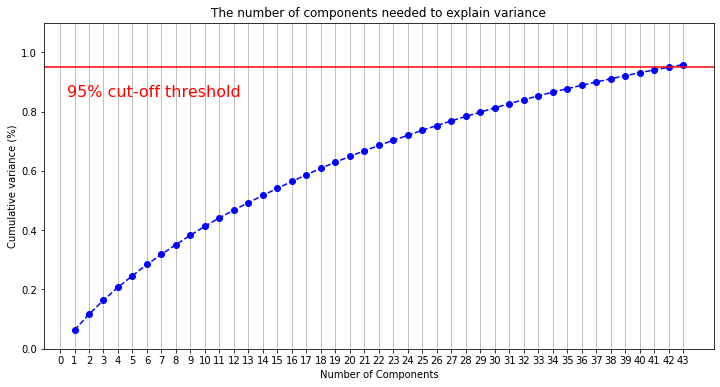

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, len(myPCA.explained_variance_ratio_)+1, step=1)
y = np.cumsum(myPCA.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(myPCA.explained_variance_ratio_)+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

Let's find the Euclidian distances between images in the PCA space.

In [ ]:
from scipy.spatial import distance_matrix

distanceMatrix = distance_matrix(components_images, components_images)

Pick a random index between [0, number of images] for an image, and find 8 different images that are closest to your random image in the PCA space. Show all 9 images, and check if they belong the same person or similar.

Also, dont forget that your random pick associated person might have only one image in the dataset.

In [ ]:
import matplotlib.image as pimage
import math
import matplotlib.pyplot as plt

# This function will plot the images if you supply closestImgPaths argument
def plot_figures(closestImgPaths, nrows = 3, ncols=3):
    """
    closestImgPaths: list of image paths i.e. ["path1", "path2", etc]
    """
    selected = [pimage.imread(path) for path in closestImgPaths]
    figures = {str(i): img  for i, img in enumerate(selected)}

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    fig.set_figheight(15)
    fig.set_figwidth(20)
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.jet())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional


# Question 3 (20 points)

Use the distance matrix computed above and assigned to `distanceMatrix` variable. Find the indices of 9 closest images and collect their indices in an array called `closestImagesIdx` below.


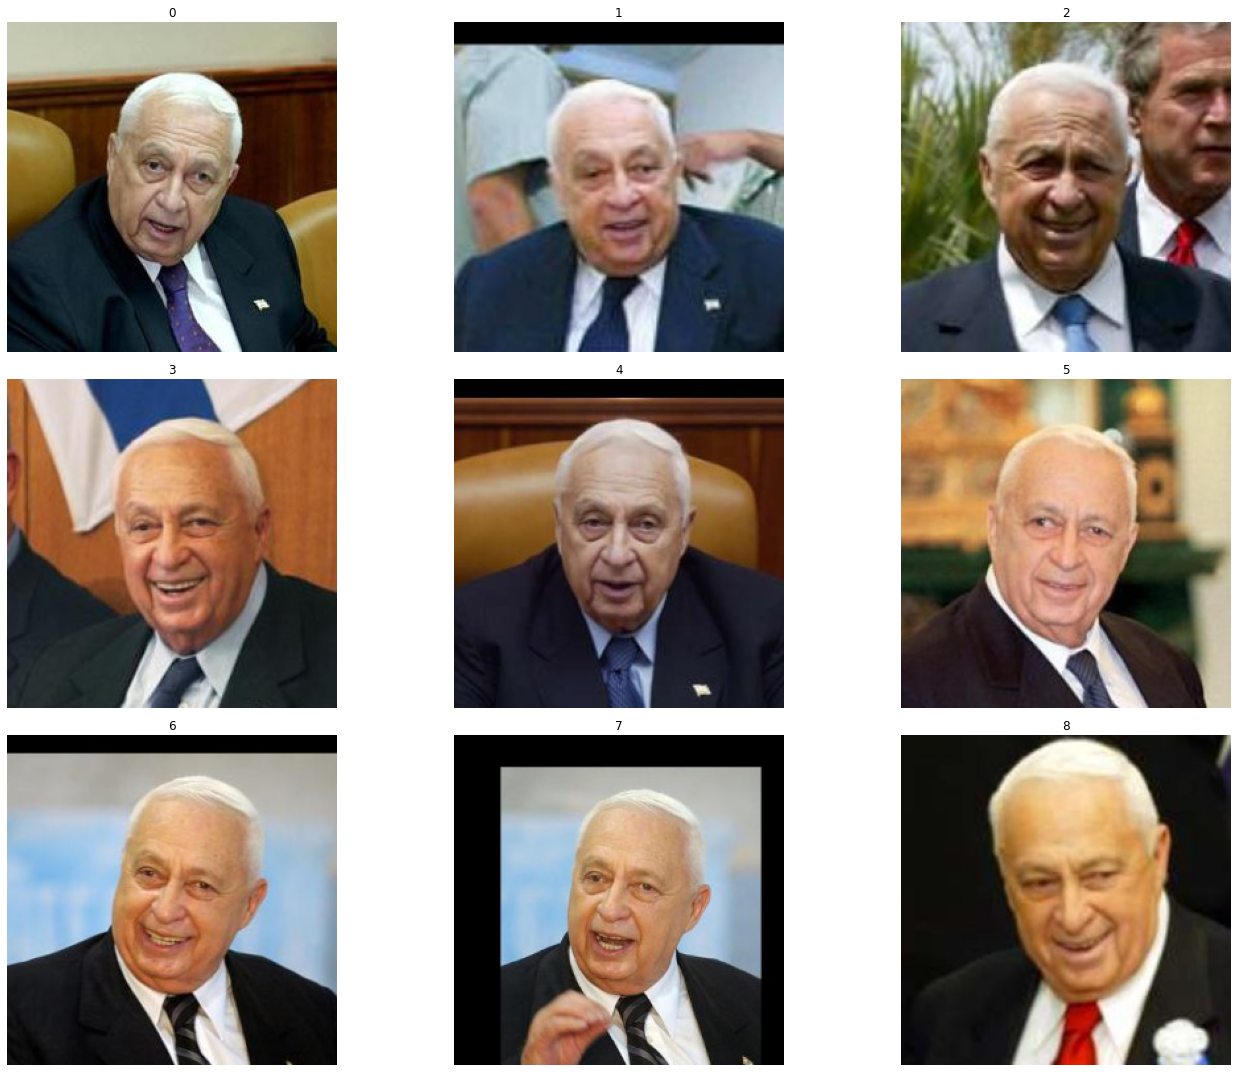

In [ ]:
import random as rnd
nClosest = 9
randomIdx = rnd.randint(0, len(image_datasets.imgs)-1)

# UPDATE THE CODE BELOW
sorted_indices = np.argsort(distanceMatrix[randomIdx])
closestImagesIdx = sorted_indices[1:10]
closestImgPaths = [image_datasets.imgs[idx][0] for idx in closestImagesIdx]
plot_figures(closestImgPaths)

# NearestNeighbors

We will follow a similar assignment with neighbor search. You will use [sklearn.neighbors.NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html).

You will fit all the embeddings to the `NearestNeighbors` object. Then, again  pick a random index between [0, number of images] for an image, and learn the closest 9 images with the `kneighbors` method.

Check if the resulting images belong the same person or similar.

# QUESTION 4 (30 points): Use `NearestNeighbors` model and find the most similar k images

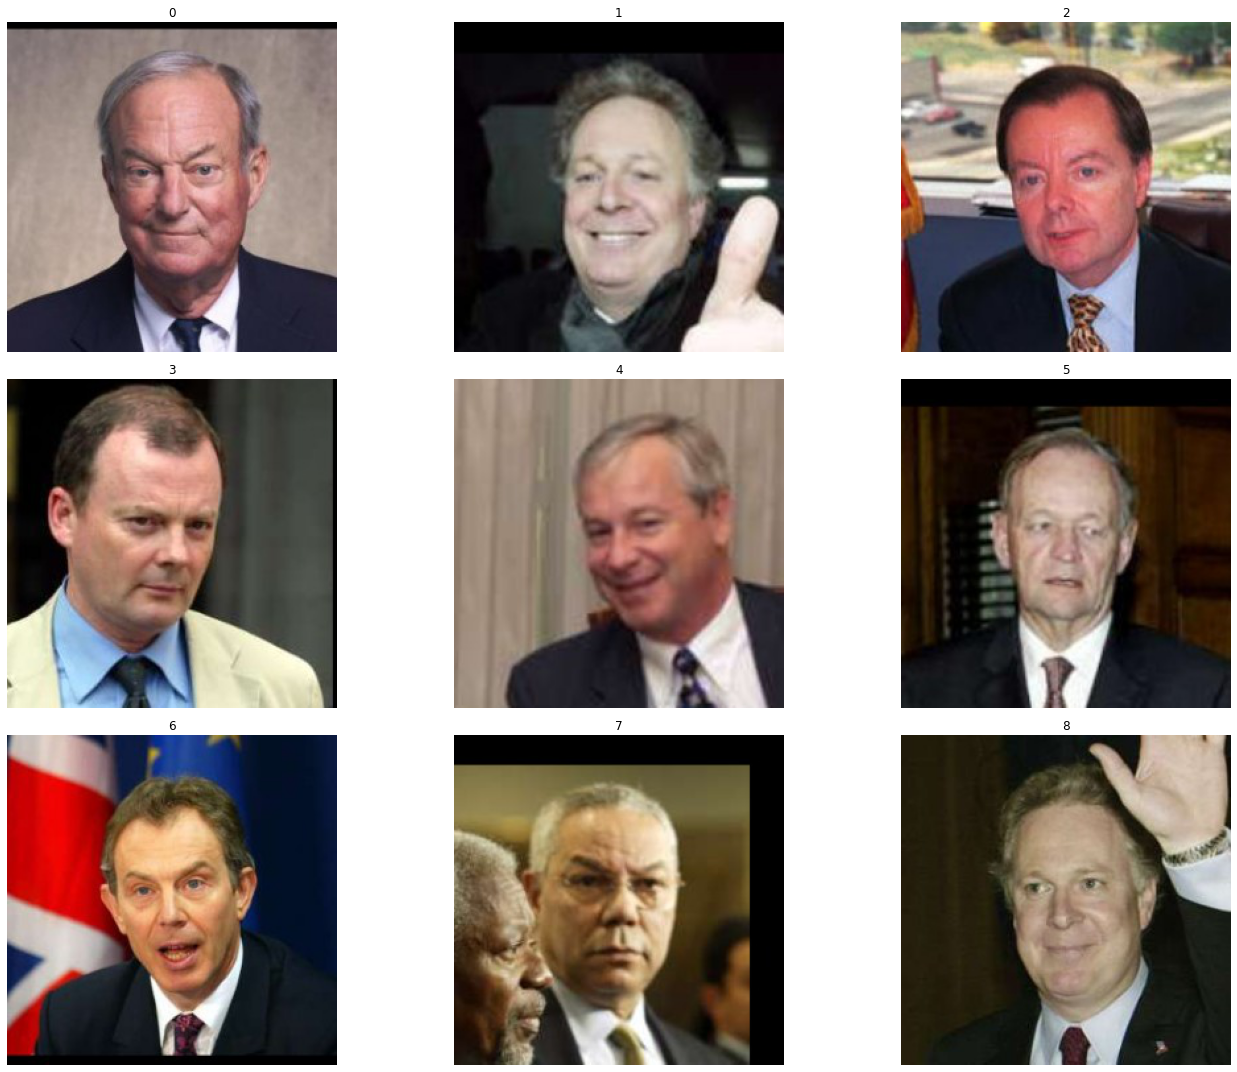

In [ ]:
from sklearn.neighbors import NearestNeighbors

k=9
random_image_idx = rnd.randint(0, len(image_datasets.imgs)-1)

# Use NearestNeighbors model below to find the most similar k images and their paths

nn = NearestNeighbors(n_neighbors=k+1) # +1 to exclude the query image itself
nn.fit(embedsList)
_, closestImagesIdx = nn.kneighbors(embedsList[random_image_idx].reshape(1,-1))
closestImagesIdx = closestImagesIdx.flatten()[1:] # remove the query image itself
closestImgPaths = [image_datasets.imgs[idx][0] for idx in closestImagesIdx]
plot_figures(closestImgPaths)
